In [1]:
import os
os.chdir(os.path.join(os.getcwd(), '..'))

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

2023-12-06 15:19:44.204211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-06 15:19:44.204255: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-06 15:19:44.205700: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-06 15:19:44.211305: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-06 15:19:45.303265: W tensorflow/compiler/tf2

scanpy==1.9.6 anndata==0.10.3 umap==0.5.4 numpy==1.26.1 scipy==1.11.3 pandas==1.5.3 scikit-learn==1.3.2 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10


## 0. Reading data into AnnData object

Since we are working with the PBMC-3k dataset and the data is encoded in .mtx format, we use `.read_10x_mtx` to read the data and load it to a AnnData object. The function asks for the path of the folder containing the .mtx file (not the path of the file) and the names we want to use for the genes (variables). By default it uses symbols but we can also call it with 'gene_ids'.

In [5]:
data_path = '/media/user/T7 Touch/PhD_Lucas/rna_sequencing/data/external/pbmc68k/'  # the directory with the `.mtx` file
results_file = 'write/pbmc68k.h5ad'      # the file that will store the analysis results

adataCopy = sc.read_10x_mtx(
    path = data_path,            # the directory with the `.mtx` file
    var_names = 'gene_symbols',  # use gene symbols for the variable names (variables-axis index)
    cache = True)    

... reading from cache file cache/media-user-T7 Touch-PhD_Lucas-rna_sequencing-data-external-pbmc68k-matrix.h5ad


/home/user/lucas-dev/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


By calling the AnnData object we can see that we have 5898240 cells (observations) and 32738 genes (variables). In this case all the variables have a unique name (identifier) but in case that we get a warning, we can call `.var_names_make_unique()` to make all the variables names unique.

In [6]:
adataCopy

AnnData object with n_obs × n_vars = 5898240 × 32738
    var: 'gene_ids'

Names of cells and genes can be accesed by calling `.obs_names` and `.var_names` respectively.

## 1. Adding annotations

We also have the annotations for ~68k cells where they class each cells in one out of 11 cell groups. To do so, we can read the .tsv file and sicne both the annotations and the `.obs` are dataframes, we can merge then by keys.

In [8]:
import pandas as pd

anno = pd.read_csv('data/external/pbmc68k/annotations.tsv', sep='\t')
anno.head()

,TSNE.1,TSNE.2,barcodes,celltype
0,7.565540,0.441370,AAACATACACCCAA-1,CD8+ Cytotoxic T
1,2.552626,-25.786672,AAACATACCCCTCA-1,CD8+/CD45RA+ Naive Cytotoxic
2,-5.771831,11.830846,AAACATACCGGAGA-1,CD4+/CD45RO+ Memory
3,1.762556,25.979346,AAACATACTAACCG-1,CD19+ B
4,-16.793856,-16.589970,AAACATACTCTTCA-1,CD4+/CD25 T Reg


We can see that the 'barcodes' column corresponds to the name of the cells. In order to not modify the original dataset (just in case we want to manipulate it later) we can make a copy of the AnnData object. We add a new column to the cells dataframe (obs) adding the values of the merged dataframe and lastly we drop all the cells that have NaN values (in the celltype column).

In [9]:
adata = adataCopy.copy()
inner = pd.merge(adata.obs, anno, left_index=True, right_on='barcodes', how='left')
adata.obs['celltype'] = inner['celltype'].values
idx = np.where(adata.obs['celltype'].notna())[0]
adata = adata[idx, :]

In [10]:
adata.write('models/adata.h5ad')

/home/user/lucas-dev/lib/python3.10/site-packages/anndata/_core/anndata.py:1292: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


## 2. Sampling with same celltype distribution

To make computations faster, we will sample a smaller dataset from the orginial one (let's say pick 10% of the total data) with a similar celltype distribution.

In [11]:
import scipy.stats as stats

cells_names = adata.obs_names
class_labels = adata.obs['celltype']

# Stratify the data
strata = {}
for label in class_labels.unique():
    strata[label] = cells_names[class_labels == label]

In [12]:
# Calculate sample sizes
strata_sample_sizes = {
    label: int(0.1 * len(stratum)) for label, stratum in strata.items()
}

# Perform stratified sampling
sample_names = np.array([])
for label, stratum in strata.items():
    sample_size = strata_sample_sizes[label]
    sample_names = np.concatenate((sample_names, np.random.choice(stratum, sample_size)))

Once we have selected the names, we can sample the data

In [13]:
idxs = np.where(np.isin(adata.obs_names, sample_names))[0]
adataSample = adata[idxs]

In [14]:
adataSample.write('models/adataSample.h5ad')

## 3. Normalization

In [15]:
adataNorm = adataSample.copy()
sc.pp.normalize_total(adataNorm, target_sum=None)
sc.pp.log1p(adataNorm)

normalizing counts per cell
    finished (0:00:00)


In [16]:
adataNorm.write('models/adataNorm.h5ad')

## 4. Imputation methods

Once we have filtered and process our data, it is time to use the imputation methods, meaning that we can try to use different methods in order to recover the technical-zeros from the sparse matrix. In this case, we will compare the cluster using no imputation as well as ALRA, MAGIC and SinkHorn.

In [28]:
normalizedMatrix = adataNorm.X.toarray().astype(float)

### 4.1. ALRA

In [18]:
import anndata as ad
from src.ALRA import choose_k, ALRA

In [19]:
k = choose_k(normalizedMatrix)
A_alra = ALRA(normalizedMatrix, k)

In [42]:
# Calculated ALRA in 36s

In [20]:
adataALRA = ad.AnnData(A_alra)
adataALRA.obs_names = adataSample.obs_names
adataALRA.obs['celltype'] = adataSample.obs['celltype']
adataALRA.var_names = adataSample.var_names

We save the AnnData object before performing any dimensionality reduction or clustering, in case we want to recover the data later.

In [26]:
adataALRA.write_h5ad('models/adataALRA.h5ad')
# adataALRA = sc.read_h5ad('models/adataALRA2.h5ad')

### 4.2. MAGIC

In [29]:
import scprep
import magic

In [30]:
magicOP = magic.MAGIC()
A_magic = magicOP.fit_transform(normalizedMatrix, genes='all_genes')
adataMAGIC = ad.AnnData(A_magic)

Calculating MAGIC...
  Running MAGIC on 6524 cells and 32738 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/home/user/lucas-dev/lib/python3.10/site-packages/magic/magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 16.74 seconds.
    Calculating KNN search...
    Calculated KNN search in 4.39 seconds.
    Calculating affinities...
    Calculated affinities in 4.26 seconds.
  Calculated graph and diffusion operator in 25.40 seconds.
  Running MAGIC with `solver='exact'` on 32738-dimensional data may take a long time. Consider denoising specific genes with `genes=<list-like>` or using `solver='approximate'`.
  Calculating imputation...
  Calculated imputation in 24.27 seconds.
Calculated MAGIC in 49.99 seconds.


In [48]:
# Calculated MAGIC in 50 seconds

In [31]:
adataMAGIC.obs_names = adataNorm.obs_names
adataMAGIC.obs['celltype'] = adataNorm.obs['celltype']
adataMAGIC.var_names = adataNorm.var_names

We save the AnnData object before performing any dimensionality reduction or clustering, in case we want to recover the data later.

In [32]:
adataMAGIC.write_h5ad('models/adataMAGIC.h5ad')
# adataMAGIC = sc.read_h5ad('models/adataMAGIC2.h5ad')

### 4.3. Sinkhorn

In [34]:
import numpy as np
from hyperimpute.plugins.imputers import Imputers

In [ ]:
A_sink = adataNorm.X.toarray().astype(float)
A_sink[A_sink == 0] = np.nan

plugin = Imputers().get("sinkhorn")
df_sink = plugin.fit_transform(A_sink)
A_sink = np.array(df_sink)

In [ ]:
adataSink = ad.AnnData(A_sink)
adataSink.obs_names = adataNorm.obs_names
adataSink.obs['celltype'] = adataNorm.obs['celltype']
adataSink.var_names = adataNorm.var_names

### 4.4. MIRACLE

## 5. Filtering

One of the previous steps before analysing the data is to treat it so that the statisticals computations make more sense. In this case, we know that scRNA-seaquencing suffers from the so called 'curse of dimensionalty'. Even though we tend to think that the more features (genes) the best to classify the observations, it is not always true. This often happens in this field where the number of variables is too high, so that there are many of them that don't actually add information, but rather noise.

We can see that the representation of the genes varies a lot. That is why we can process the data and keep only the cells or genes that verify certain conditions. For instance, we can acces all the pre-processing functions by calling `.pp`. For example, we can filter both cells and genes separately using `.filter_cells` and `.filter_genes`. The changes are made inplace by default, so that the AnnData will be changed directly. In order to keep the original data intacted, we can make a copy and modify this copy. This can be done with `.copy()` and its a tool we will be using along.

The chosen filters are the same as those in the "Zero-preserving imputation of single-cell RNA-seq data" article.
1. Cells with less than 400 genes are filtered out.
2. Genes expressed in less than 6 cells are filtered out.

In [46]:
adataNorm = sc.read_h5ad('models/adataNorm.h5ad')
adataALRA = sc.read_h5ad('models/adataALRA.h5ad')
adataMAGIC = sc.read_h5ad('models/adataMAGIC.h5ad')

In [47]:
dataList = [adataNorm, adataALRA, adataMAGIC]
dataNames = ["No imputation", "ALRA", "MAGIC"]

In [48]:
for name,data in zip(dataNames,dataList):
    print(name)
    sc.pp.filter_cells(data, min_genes=400)
    sc.pp.filter_genes(data, min_cells=6)
    print('')

No imputation
filtered out 940 cells that have less than 400 genes expressed


filtered out 20740 genes that are detected in less than 6 cells

ALRA
filtered out 17550 genes that are detected in less than 6 cells

MAGIC
filtered out 16584 genes that are detected in less than 6 cells



## 6. Dimensionality reduction

### 6.1. PCA

PCA creates a new set of uncorrelated variables, so called principle components (PCs), via an orthogonal transformation of the original dataset. The PCs are linear combinations of features in the original dataset and are ranked with decreasing order of variance to define the transformation. Through the ranking usually the first PC amounts to the largest possible variance. PCs with the lowest variance are discarded to effectively reduce the dimensionality of the data without losing information.

In order to apply it to our data, first we need to perform the method via `.tl.pap` or `.pp.pca` (they are actually the same function) and then scatter plot it using `.pl.pca`. To plot it we only need to pass the AnnData object since it will look for the components saved in `uns`, `obsm` and `varm`. In case we want the scatter plot to be colored, we can add which variable to take into account (or cell/gene).

computing PCA


    with n_comps=30
    finished (0:00:05)


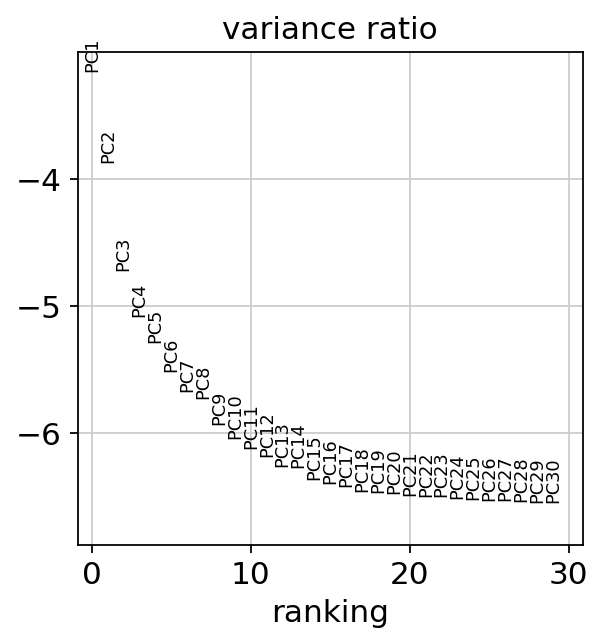

computing PCA
    with n_comps=30
    finished (0:00:10)


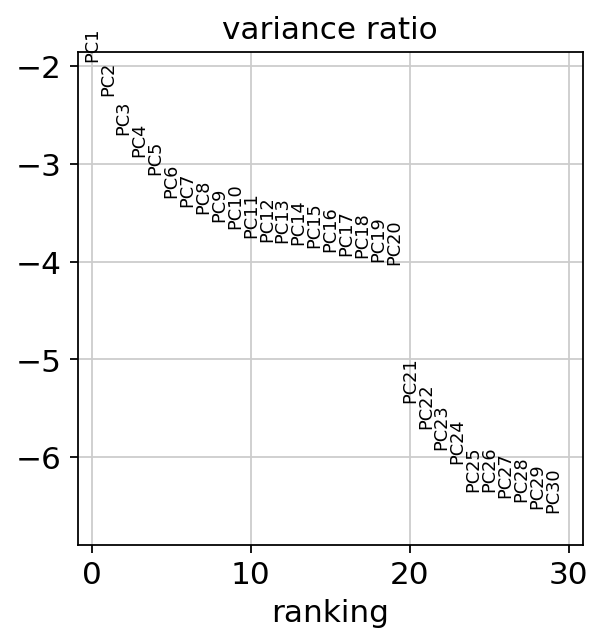

computing PCA
    with n_comps=30
    finished (0:00:10)


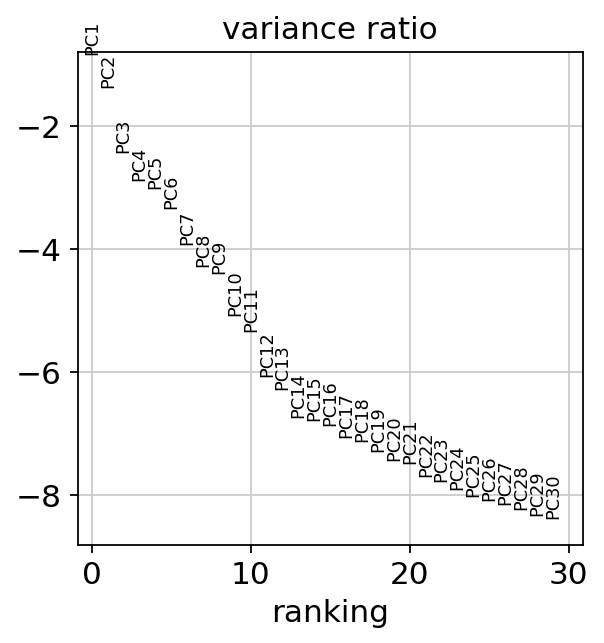

In [49]:
for i,data in enumerate(dataList):
    sc.pp.calculate_qc_metrics(data, percent_top=None, log1p=False, inplace=True)
    sc.tl.pca(data, svd_solver='arpack', n_comps=30)
    sc.pl.pca_variance_ratio(data, log=True, n_pcs=30, show=True)

### 6.2. Clustering

Once one has performed the reduciton of dimension to the data, we can actually visulize it in a 2D or 3D graph. Then, clustering mehtods can be applied to this reduced data in order to group the principal components. To do so, we can use different clustering mehtods available in the `scanpy` module. Here we will show two of them, which make use of a graph structure on the data.

That is why we will need first to calculate the KNN graph on the lower-dimentional data using the `.pp.neighbors`. Appart from the data, we also need to provide the number of principal components we want to use (how many dimensions out of the total ones we want to keep). This is an important choice and it will depend on the percentage of information that each principal component carries. We can see this using the `.pl.pca_variance_ratio` function over the data.

We can perform this algorithm using the `.tl.leiden` function and by passing the reduced data with the KNN graph already performed and the resolution parameter (1 by default) which quantifies (in a way) the number of clusters. We can also pass the `neighbors_key` in case we have performed multiple KNN graphs and the `key_added` is case we use different resolutions parameters to compare them.

In [50]:
from sklearn.cluster import KMeans
import numpy as np

for name,data in zip(dataNames,dataList):
    print(name)
    matrix = data.X
    if type(matrix) != np.ndarray:
        matrix = matrix.toarray()

    kmeans = KMeans(n_clusters=11, random_state=0, n_init="auto").fit(matrix)
    data.obs['kmeans'] = kmeans.labels_
    data.obs['kmeans'] = data.obs['kmeans'].astype('string')
    print('')

No imputation

ALRA

MAGIC



In [51]:
for name,data in zip(dataNames,dataList):
    print(name)
    sc.pp.neighbors(data, n_pcs=20, use_rep='X')
    sc.tl.umap(data)
    print('')

No imputation
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)

ALRA
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)

MAGIC
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)



In [52]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

for name,data in zip(dataNames,dataList):
    # Convert string labels to numerical labels
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(data.obs['celltype'])
    kmeans_labels = data.obs['kmeans'].astype(int)

    # Calculate Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(true_labels, kmeans_labels)

    # Calculate Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(true_labels, kmeans_labels)

    print(name)
    print("Adjusted Rand Index (ARI):", np.round(ari, 3))
    print("Normalized Mutual Information (NMI):", np.round(nmi, 3),'\n')

No imputation
Adjusted Rand Index (ARI): 0.241
Normalized Mutual Information (NMI): 0.414 

ALRA
Adjusted Rand Index (ARI): 0.251
Normalized Mutual Information (NMI): 0.458 

MAGIC
Adjusted Rand Index (ARI): 0.287
Normalized Mutual Information (NMI): 0.497 



/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


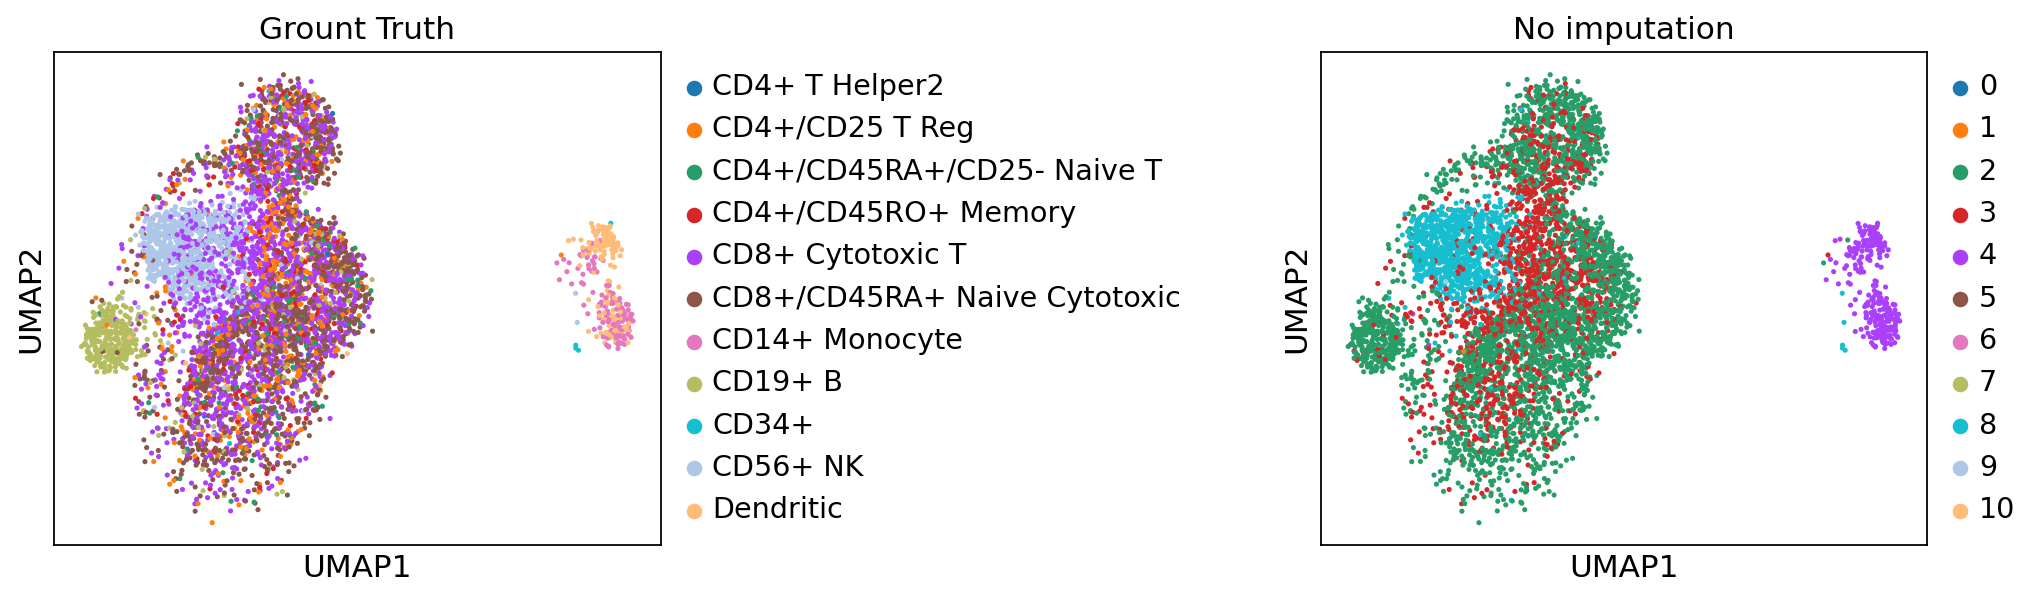

In [53]:
sc.pl.umap(adataNorm,
           color=['celltype', 'kmeans'],
           title=['Grount Truth', 'No imputation'],
           legend_loc="right margin",
           wspace=0.9)

/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


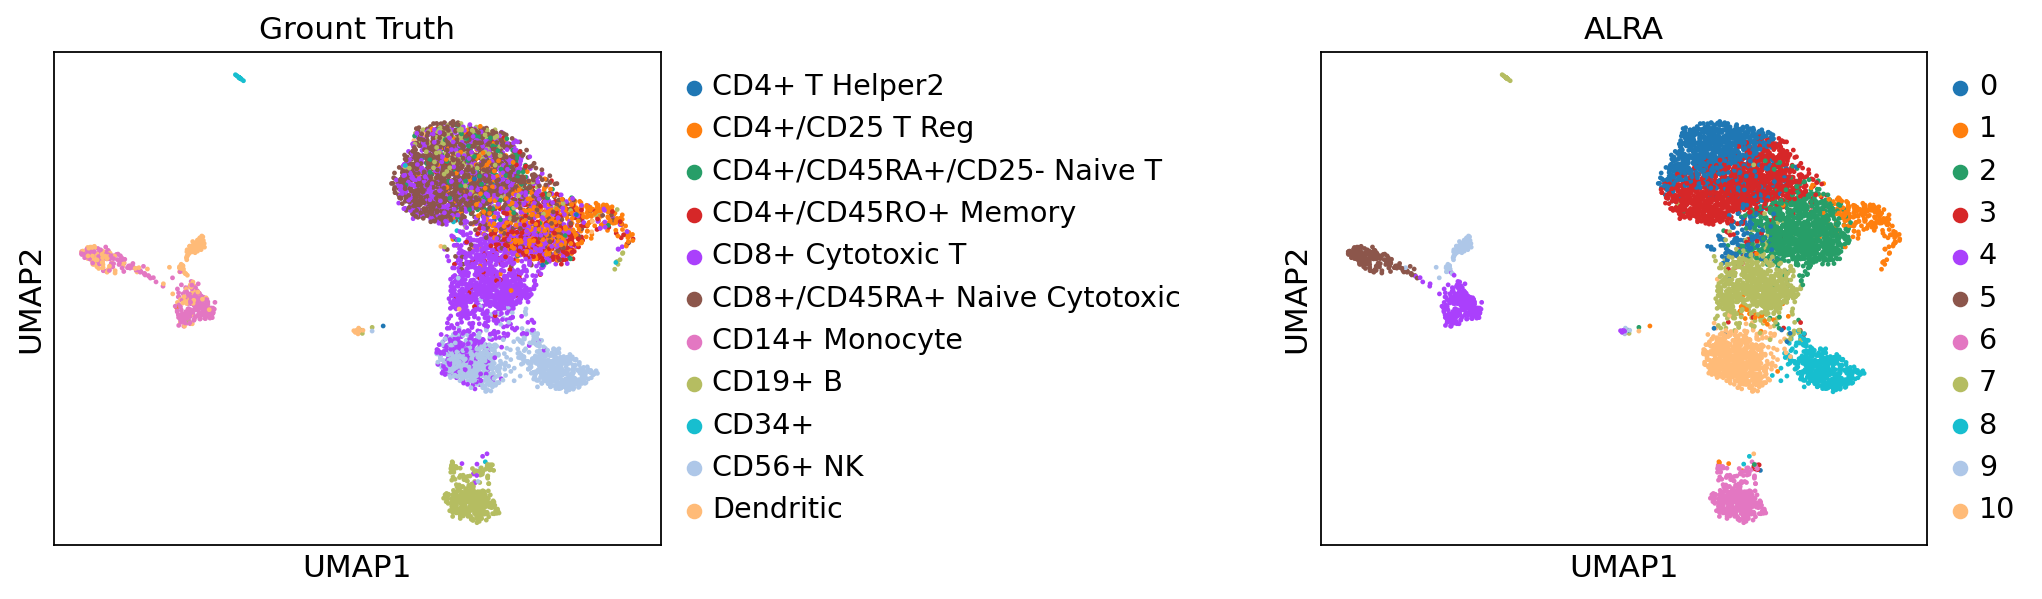

In [54]:
sc.pl.umap(adataALRA,
           color=['celltype', 'kmeans'],
           title=['Grount Truth', 'ALRA'],
           legend_loc="right margin",
           wspace=0.9)

/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/user/lucas-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


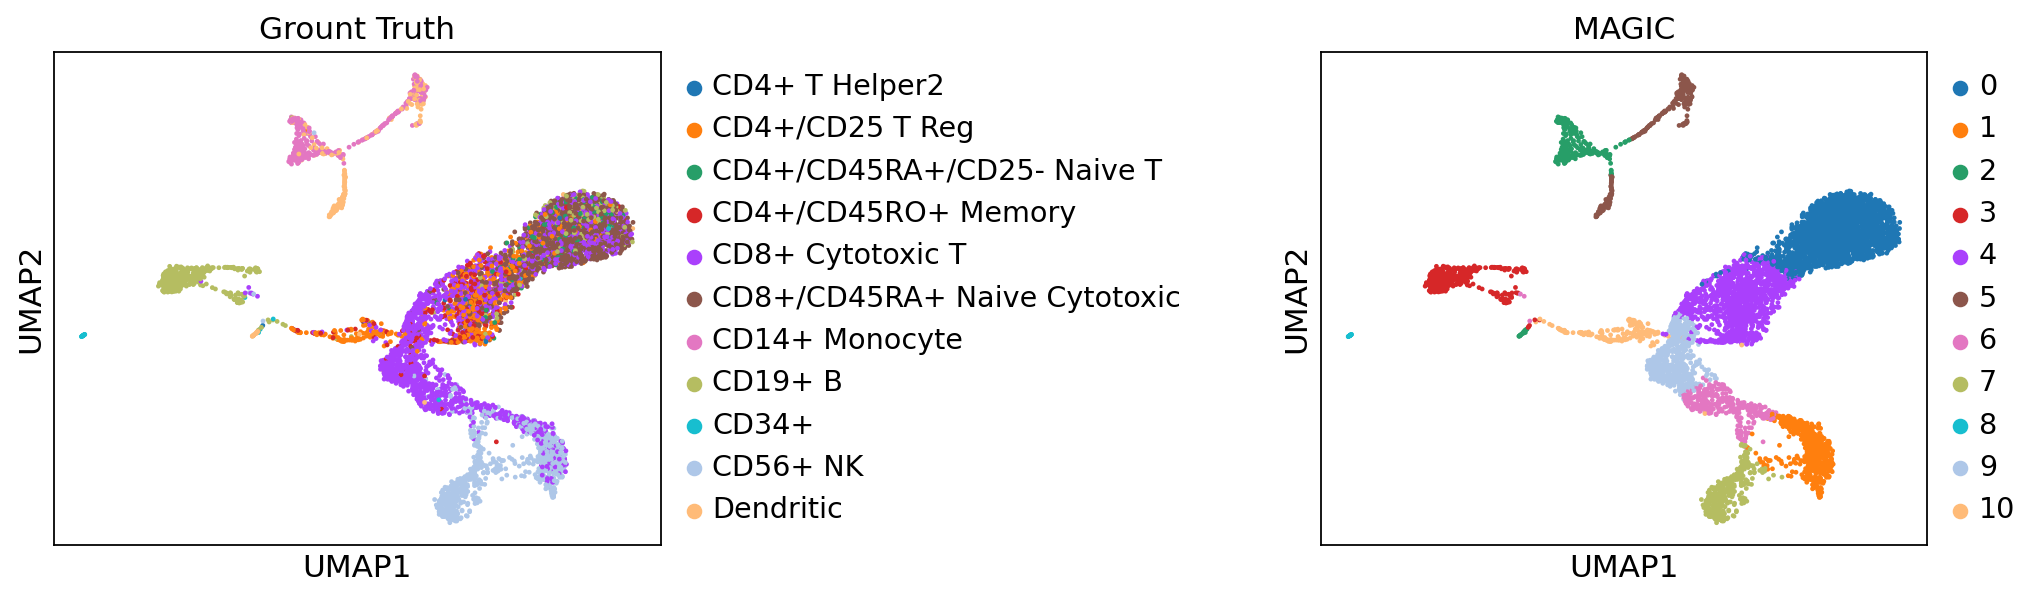

In [55]:
sc.pl.umap(adataMAGIC,
           color=['celltype', 'kmeans'],
           title=['Grount Truth', 'MAGIC'],
           legend_loc="right margin",
           wspace=0.9)